# FTICR-MS Processing and Display of Phase-Sensitive spectra

### *This is a preliminary version - use with caution*

a simplified environment for processing 1D Bruker FTICR datasets with `SPIKE`

Run each python cell in sequence by using the ⇥Run button above (or typing *shift* Enter).

Cells are meant to be used in order, taking you to the complete analysis, but you can go back at any time.

### Initialization of the environment
the following cell should be run only once, at the beginning of the processing

## STARTING Environment...


          SPIKE
    Version     : 0.99.32
    Date        : 08-02-2023
    Revision Id : 586

loading plugins... ( use spike.plugins.report() for a short description of each plugins )
*** zoom3D not loaded ***
generic plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
user plugins loaded:
msapmin, 
MS plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 
NMR plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  PALMA,  apmin, 

Interactive module version, 1.3.0


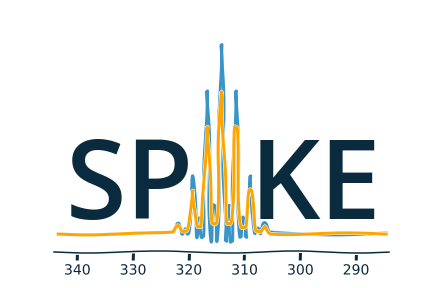

Run date: 2023-03-09T19:33:07.512921


## ...program is Ready

In [1]:
# load all python and interactive tools - should be run only once
from IPython.display import display, HTML, Markdown, Image
display(Markdown('## STARTING Environment...'))
import matplotlib as mpl
%matplotlib widget
import spike
from spike.File import BrukerMS
from spike.Interactive import INTER as I
from spike.Interactive import FTICR_INTER as FI
from spike.Interactive import INTER_MS as IMS
from spike.Interactive.ipyfilechooser import FileChooser
I.initialize()
from datetime import datetime
print('Run date:', datetime.now().isoformat() )
display(Markdown('## ...program is Ready'))
from importlib import reload  # this line is debugging help

# configurable items
mpl.rcParams['figure.figsize'] = (8,4)   # (X,Y) default figure size
I.Activate_Wheel = True                  # True/False wheel control in the graphic cells 

### Choose the file
Use `FileChooser()` to choose a file on your disk - The optional `base` argument, starts the exploration on a given location.

Bruker files are named `fid` and are contained in a `*.d` directory.

In [3]:
FC = FileChooser(filetype='fid')
display(FC)

FileChooser(path='/home/mad/Documents/spike/Notebooks', filename='', show_hidden='False')

(After the selection, the selected filename is found in the `FC.selected` variable)
### Import dataset


In [4]:
# This is simply done with the `Import_1D()` tool, which returns a `SPIKE` object.
# We store it into a variable, evaluating the variable show a summary of the dataset. 
print('Reading file ',FC.selected)
d1 = BrukerMS.Import_1D(FC.selected)
d1.filename = FC.selected
d1.set_unit('sec').display(title=FC.selected_path+" transient")
d1

Reading file  /DATA/DATA/FT-ICR/Zherebker_21_06_21/pos-Glutathione-internal_000001.d/fid
Using 3 parameters calibration,  Warning calibB is -ML2


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 7.05
Single Spectrum data-set
FT-ICR axis at 714.285714 kHz,  4194304 real points,  from physical mz =  151.655   to m/z = 1500.000  R max (M=400) = 1590317

### First Compute Modulus Spectrum

many processing methods are available, they can be either applied one by one, or piped by chaining them.

Here we are chaining  apodisation - zerofill - FT - modulus

then setting to `m/z` unit (`Hz` and `points` also available) - finally `display()` is used to display the dataset.


In [5]:
D1md = d1.copy() # copy the imported data-set to another object for processing
D1md.kaiser(4).zf(4).rfft().modulus() # kaiser(4) is an apodisation well adapted to FTICR, slightly more resolution than hamming(
D1md.set_unit('m/z')  # set to ppm unit - and display
I.Show1D(D1md, title=FC.selected_path)

Show1D(children=(VBox(children=(Button(button_style='success', description='Reset', layout=Layout(width='80px'…

# the interactive phaser.

we'll apply a phase correction $\phi \propto p_o + p_1 f_w + p_2 f_w^2$ where $f_w$ is the frequency of the FTICR signal across the spectral width

$p_0$ is expressed in degrees, $p_1, p_2$ are expressed in number of of full turns over the spectral width.

In interactive mode, there is also a $pivot$,  it is the location where P1 and P2 are inactive.
It is a convenience for interaction,  P0 P1 and P2 are equal to $p_o, p_1$ and $p_2$ for $pivot=0$ i.e. on the left side.
Moving the pivot modifies the interactive values of P0 and P1, don't worry.

**Recipe**

- 1/ start it below - spectrum is displayed in $Hz$
    - a very rough first guess is already in place
    - (optionally, set the values to zero)
- 2/ zoom on a low frequency massive (on the left of the spectrum - corresponds to high masses)  
    - a/ the chose zoom should be quite populated on a wide enough range - use scale on the side to have it full screen
    - b/ right click on the center - this defines the pivot location
    - c/ use P0 to put the central line in absorption
    - d/ use P1 to extend the absorption zone as far as possible, try to be as precise as possible
        - if possible, try to zoom out and continue extending
    - e/ once it's Ok, click on **"Add Entry"**
- 3/ zoom on a high frequency massive (low masses)
    - redo steps a/ to d/ above
    - once you're fine, you can click on **"Add Entry"**, this will modify the value of P2 automatically
- 4/ redo step 3/ in many different location until is seems that you have a large zone in the middle of the spectrum which is phased.
    - if you're lost, or if P2 does not stabilises, you can always clear the list, keeping the phase correction, but restarting the P2 computation.
    - you can always restart the cell
- 5/ now with the whole spectrum on the zoom, 
    - set the pivot in the center
    - touch P0 to phase the center
    - touch P1 to extend the phase region
    - then slightly touch P2 to extend further the phased region
- **Done**

In [7]:
simax = min(512*1024, d1.size1)
D1ph = d1.copy()       # copy the imported data-set to another object for processing
D1ph.apod_sq_sin(maxi=0).chsize(simax).zf(2).rfft()
#D1ph.apod_sin(maxi=0.35).rfft()
reload(IMS)
print ("initial values P1: %.0f   P2: %.0f"%IMS.firstguess(d1))
IMS.Phaser1D(D1ph.set_unit('Hz'), title=FC.selected_path);

initial values P1: 841   P2: 8204


Phaser1D(children=(VBox(children=(HBox(children=(Button(button_style='success', description='Done', style=Butt…

### And now compute the full version

In [10]:
D1 = d1.copy() # copy the imported data-set to another object for processing
D1.apod_sin(maxi=0.15).zf(4).rfft()
D1.phaseMS(D1ph.axis1.P0, D1ph.axis1.P1, D1ph.axis1.P2,0.0).real()

FTICR data-set
Bo: 7.05
Single Spectrum data-set
FT-ICR axis at 535.714286 kHz,  1048576 real points,  from physical mz =  202.203   to m/z = 1500.000  R max (M=400) = 530100

### baseline correction, and display

In [14]:
from spike.plugins.bcorr import autopoints
xp = autopoints(D1md, int(2*D1ph.axis1.P2))
D1.bcorr(method='spline', xpoints=xp, nsmooth=2)
D1.set_unit('m/z').display(title=FC.selected_path)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 7.05
Single Spectrum data-set
FT-ICR axis at 535.714286 kHz,  1048576 real points,  from physical mz =  202.203   to m/z = 1500.000  R max (M=400) = 530100

# Compare phase-sensitive and modulus !

In [13]:
D1.set_unit('m/z').display(title=FC.selected_path, label='phase-sensitive')
D1md.set_unit('m/z').display(new_fig=False, label='modulus')
#plt.scatter(D1bc.axis1.itomz(xp), D1bc.buffer[xp], marker='.', c='r')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 7.05
Single Spectrum data-set
FT-ICR axis at 535.714286 kHz,  1048576 real points,  from physical mz =  202.203   to m/z = 1500.000  R max (M=400) = 530100